In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pylab as plt
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LassoLarsCV
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

/Users/dmitry/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Data Engineering

In [2]:
#Load the dataset
data = pd.read_csv("adult.data.txt", header=None)
columns = [
    'pred_age', 'workclass', 'fnlwgt', 'education', 
    'education-cat', 'marital-status', 'occupation', 
    'relationship', 'race', 'sex', 'capital-gain', 
    'capital-loss', 'hours-per-week', 'native-country',
    'age'
]
data.columns = columns

# Is dublication of education-num column
data.drop(['education'], inplace=True, axis=1)

print(data.shape)
data.head(5) # First 5 rows

(32561, 14)


,pred_age,workclass,fnlwgt,education-cat,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,age
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### One Hot Encoding

In [3]:
categorical_vars = (
    'workclass', 'marital-status', 'occupation',
    'relationship', 'race', 'sex', 'native-country',
    'age'
)

for column in categorical_vars:
    data = data.join(
        pd.get_dummies(
            data[[column]], 
            prefix=column[:3], 
            drop_first=True
        )
    )
    data.drop([column], inplace=True, axis=1)

print(data.shape)
data.head(5)

(32561, 86)


,pred_age,fnlwgt,education-cat,capital-gain,capital-loss,hours-per-week,wor_ Federal-gov,wor_ Local-gov,wor_ Never-worked,wor_ Private,...,nat_ Puerto-Rico,nat_ Scotland,nat_ South,nat_ Taiwan,nat_ Thailand,nat_ Trinadad&Tobago,nat_ United-States,nat_ Vietnam,nat_ Yugoslavia,age_ >50K
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,215646,9,0,0,40,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,53,234721,7,0,0,40,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,28,338409,13,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [4]:
target = data.pred_age
pred_predictors = data.loc[:, data.columns != 'pred_age']
predictors=pred_predictors.copy()

# Standardize predictors to have mean=0 and sd=1
for column_name in pred_predictors.columns:
    predictors[column_name]=preprocessing.scale(predictors[column_name].astype('float64'))
predictors.head(5)

,fnlwgt,education-cat,capital-gain,capital-loss,hours-per-week,wor_ Federal-gov,wor_ Local-gov,wor_ Never-worked,wor_ Private,wor_ Self-emp-inc,...,nat_ Puerto-Rico,nat_ Scotland,nat_ South,nat_ Taiwan,nat_ Thailand,nat_ Trinadad&Tobago,nat_ United-States,nat_ Vietnam,nat_ Yugoslavia,age_ >50K
0,-1.063611,1.134739,0.148453,-0.21666,-0.035429,-0.174295,-0.262097,-0.014664,-1.516792,-0.188389,...,-0.059274,-0.019201,-0.049628,-0.039607,-0.023518,-0.024163,0.340954,-0.045408,-0.022173,-0.563199
1,-1.008707,1.134739,-0.145920,-0.21666,-2.222153,-0.174295,-0.262097,-0.014664,-1.516792,-0.188389,...,-0.059274,-0.019201,-0.049628,-0.039607,-0.023518,-0.024163,0.340954,-0.045408,-0.022173,-0.563199
2,0.245079,-0.420060,-0.145920,-0.21666,-0.035429,-0.174295,-0.262097,-0.014664,0.659286,-0.188389,...,-0.059274,-0.019201,-0.049628,-0.039607,-0.023518,-0.024163,0.340954,-0.045408,-0.022173,-0.563199
3,0.425801,-1.197459,-0.145920,-0.21666,-0.035429,-0.174295,-0.262097,-0.014664,0.659286,-0.188389,...,-0.059274,-0.019201,-0.049628,-0.039607,-0.023518,-0.024163,0.340954,-0.045408,-0.022173,-0.563199
4,1.408176,1.134739,-0.145920,-0.21666,-0.035429,-0.174295,-0.262097,-0.014664,0.659286,-0.188389,...,-0.059274,-0.019201,-0.049628,-0.039607,-0.023518,-0.024163,-2.932948,-0.045408,-0.022173,-0.563199


### Modelling and prediction

In [5]:
# Split data into train and test sets
pred_train, pred_test, tar_train, tar_test = train_test_split(
    predictors, 
    target,                                                       
    test_size=.3, 
    random_state=123
)

In [6]:
# Specify the lasso regression model
model = LassoLarsCV(cv=10, precompute=False).fit(pred_train, tar_train)

In [7]:
# Variable names and regression coefficients
dict(zip(predictors.columns, model.coef_))

{'age_ >50K': 1.1015937309743771,
 'capital-gain': 0.36603158820018594,
 'capital-loss': 0.18783533164146857,
 'education-cat': -0.74982058731388845,
 'fnlwgt': -0.65719423331589832,
 'hours-per-week': -1.0821434798699525,
 'mar_ Married-AF-spouse': -0.33735611003841481,
 'mar_ Married-civ-spouse': -2.6039405247520202,
 'mar_ Married-spouse-absent': -0.22575375186684365,
 'mar_ Never-married': -5.6411475858284899,
 'mar_ Separated': -0.55304697813940251,
 'mar_ Widowed': 2.4119427769375199,
 'nat_ Cambodia': -0.012721700066938029,
 'nat_ Canada': 0.096050964157352106,
 'nat_ China': 0.041875457131916538,
 'nat_ Columbia': 0.15753451251671022,
 'nat_ Cuba': 0.28722684325507819,
 'nat_ Dominican-Republic': 0.077472780608394645,
 'nat_ Ecuador': -0.016664523229050134,
 'nat_ El-Salvador': -0.1011427771084126,
 'nat_ England': 0.078863600554045871,
 'nat_ France': -0.0084762375521449437,
 'nat_ Germany': -0.04556251353165116,
 'nat_ Greece': 0.1718350364947028,
 'nat_ Guatemala': -0.100379

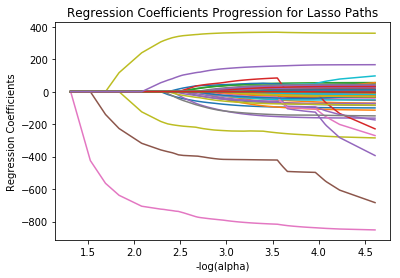

In [8]:
# Plot coefficient progression
m_log_alphas = -np.log10(model.alphas_)

plt.ylabel('Regression Coefficients')
plt.xlabel('-log(alpha)')
plt.title('Regression Coefficients Progression for Lasso Paths')

# This line doesn't work. 
# Error message: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
# plt.axvline(-np.log10(model.alphas_), linestyle='--', color='k',label='alpha CV')

plt.plot(m_log_alphas, model.coef_path_.T)
plt.show()

/Users/dmitry/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function cv_mse_path_ is deprecated; Attribute ``cv_mse_path_`` is deprecated in 0.18 and will be removed in 0.20. Use ``mse_path_`` instead
  warnings.warn(msg, category=DeprecationWarning)
/Users/dmitry/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function cv_mse_path_ is deprecated; Attribute ``cv_mse_path_`` is deprecated in 0.18 and will be removed in 0.20. Use ``mse_path_`` instead
  warnings.warn(msg, category=DeprecationWarning)


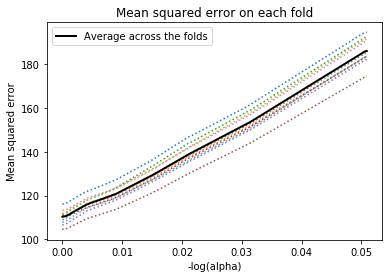

In [9]:
plt.figure()
plt.plot(model.cv_alphas_, model.cv_mse_path_, ':')
plt.plot(model.cv_alphas_, model.cv_mse_path_.mean(axis=-1), 'k', label='Average across the folds', linewidth=2)

# This line doesn't work. 
# Error message: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
#  plt.axvline(model.cv_alphas_, linestyle='--', color='k', label='alpha CV')

plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean squared error')
plt.title('Mean squared error on each fold')
plt.show()

In [10]:
# MSE from training and test data
train_error = mean_squared_error(tar_train, model.predict(pred_train))
test_error = mean_squared_error(tar_test, model.predict(pred_test))
print ('training data MSE: {}'.format(train_error))
print ('test data MSE: {}'.format(test_error))

training data MSE: 109.3570894311817
test data MSE: 108.68553645683225


In [11]:
# R-square from training and test data
rsquared_train=model.score(pred_train,tar_train)
rsquared_test=model.score(pred_test,tar_test)
print ('training data R-square: {}'.format(rsquared_train))
print ('test data R-square: {}'.format(rsquared_test))

training data R-square: 0.4120319881834278
test data R-square: 0.41629984629589
